# 戦略・銘柄毎のシグナル判定（オシレーター・日足・ブログ用）

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## ta-libにない関数の定義

In [2]:
# Elder's Force Index (EFI)
def elder_force_index(df, period=2):
    df['EFI'] = (df['Close'] - df['Close'].shift(1)) * df['Volume']
    df['EFI_Smoothed'] = df['EFI'].rolling(window=period).mean()
    return df['EFI_Smoothed']

# true_strength_index (TSI)
def true_strength_index(df, short_period=13, long_period=25):
    df['Change'] = df['Close'] - df['Close'].shift(1)
    df['Smoothed1'] = df['Change'].ewm(span=short_period, adjust=False).mean()
    df['Smoothed2'] = df['Smoothed1'].ewm(span=long_period, adjust=False).mean()
    df['AbsChange'] = abs(df['Change'])
    df['AbsSmoothed1'] = df['AbsChange'].ewm(span=short_period, adjust=False).mean()
    df['AbsSmoothed2'] = df['AbsSmoothed1'].ewm(span=long_period, adjust=False).mean()
    df['TSI'] = (df['Smoothed2'] / df['AbsSmoothed2']) * 100
    return df['TSI']

# awesome oscillator (AO)
def awesome_oscillator(df, wshort=5, wlong=34):
  df['med'] = (df['High']+df['Low']) / 2
  df['ao'] = df['med'].rolling(wshort).mean() - df['med'].rolling(wlong).mean()
  df['ado'] = df['ao'] - df['ao'].rolling(wshort).mean()
  return df['ao'], df['ado']

## シグナル検出用関数

In [3]:
# クロスオーバーとクロスアンダー及びしきい値クロス関数
def crossover(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def overthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossunder(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

def underthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

## パフォーマンス評価（バックテスト）

In [4]:
def evaluate_performance(data):
    cumulative_return = data['Portfolio_Value'].iloc[-1] / data['Portfolio_Value'].iloc[0] - 1
    volatility = data['Daily_Return'].std() * (252**0.5)
    sharpe_ratio = (data['Daily_Return'].mean() / data['Daily_Return'].std()) * (252**0.5)
    return {
        "Cumulative Return": cumulative_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

## 指標別のシグナル判定とポジション判定

In [5]:
# Elder's Force Index (EFI)ゼロクロスによるシグナル判定とポジション判定
def EFI_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate EFI
    df1['EFI'] = elder_force_index(df)
    # BUY/SELL signal conditions
    df1['EFI_buySignal'] = overthreshold(df1['EFI'], 0)
    df1['EFI_sellSignal'] = underthreshold(df1['EFI'], 0)
    # position
    df1['EFI_Position'] = [1 if x >= 0 else -1 for x in df1['EFI']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','EFI_buySignal','EFI_sellSignal','EFI_Position']]

In [6]:
# True Strength Index (TSI)ゼロクロスによるシグナル判定とポジション判定
def TSI_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate TSI
    df1['TSI'] = true_strength_index(df)
    # BUY/SELL signal conditions
    df1['TSI_buySignal'] = overthreshold(df1['TSI'], 0)
    df1['TSI_sellSignal'] = underthreshold(df1['TSI'], 0)
    # position
    df1['TSI_Position'] = [1 if x >= 0 else -1 for x in df1['TSI']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','TSI_buySignal','TSI_sellSignal','TSI_Position']]

In [7]:
# Awesome Oscillator (AO)ゼロクロスによるシグナル判定とポジション判定
def AO_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate AO
    df1['AO'], df1['ADO'] = awesome_oscillator(df)
    # BUY/SELL signal conditions
    df1['AO_buySignal'] = overthreshold(df1['AO'], 0)
    df1['AO_sellSignal'] = underthreshold(df1['AO'], 0)
    # position
    df1['AO_Position'] = [1 if x >= 0 else -1 for x in df1['AO']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','AO_buySignal','AO_sellSignal','AO_Position']]

In [8]:
# 評価する銘柄のリスト
list_ticker = ['9984.T','7203.T','5803.T']
# 期間の指定
end_date = datetime.today()
start_date = end_date - timedelta(days=1068)

In [9]:
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for symbol in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(symbol, start_date, end_date)
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    data['ticker'] = symbol
    df = data.reset_index().rename(columns={'Date':'timestamp'})
    # リターンの計算
    df['Returns'] = df['Close'].pct_change()
    ## Elder's Force Index (EFI)ゼロクロスによるシグナル判定の実施
    df_EfiZero = EFI_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_EfiZero, how="inner", on=['timestamp','ticker'])
    ## True Strength Index (TSI)ゼロクロスによるシグナル判定の実施
    df_TsiZero = TSI_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_TsiZero, how="inner", on=['timestamp','ticker'])
    ## Awesome oscillator (AO)ゼロクロスによるシグナル判定の実施
    df_AoZero = AO_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_AoZero, how="inner", on=['timestamp','ticker'])
    # 一銘柄のシグナル判定結果を元のデータに縦連結する
    df0 = pd.concat([df0,df],axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## チャートによるシグナルの検証及びパフォーマンス評価

In [10]:
# 銘柄と指標の指定
f_ticker = '5803.T'
f_ind = 'AO'
# 特定の銘柄のデータを取り出す
df = df0[df0['ticker'].str.contains(f_ticker)]

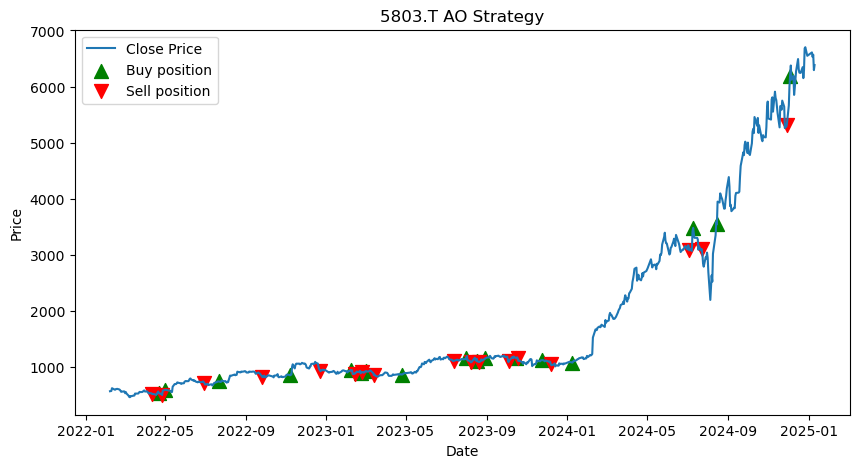

In [11]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df[f_ind+'_buySignal']], df['Close'][df[f_ind+'_buySignal']], \
            color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df[f_ind+'_sellSignal']], df['Close'][df[f_ind+'_sellSignal']], \
            color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f_ticker + ' ' + f_ind + ' Strategy')
# チャートの表示
plt.show()

In [12]:
# バックテスト
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data[f_ind+'_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print(f_ticker + ' ' + f_ind + '  Performance')
print(performance)

5803.T AO  Performance
{'Cumulative Return': 0.4043658781915802, 'Volatility': 0.5160520564027478, 'Sharpe Ratio': 0.486518863885625}
